In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import hashlib

In [299]:
def legendre_symbol(a, p):
  return pow(a, (p - 1) // 2, p)

def tonelli(n, p): 
  q = p - 1
  s = 0 
  while q % 2 == 0: 
    q //= 2 
    s += 1 
  if s == 1: 
    return pow(n, (p+1) // 4, p)
  for z in range(2, p): 
    if p-1 == legendre_symbol(z, p): 
      break 
  c = pow(z, q, p) 
  r = pow(n, (q+1) // 2, p) 
  t = pow(n, q, p)
  m = s 
  t2 = 0 

  while (t-1) % p != 0: 
    t2 = (t*t) % p 
    for i in range(1, m): 
      if (t2 - 1) % p == 0: 
        break 
      t2 = (t2 * t2) % p 
    b = pow(c, 1 << (m - i - 1), p)
    r = (r * b) % p 
    c = (b * b) % p 
    t = (t * c) % p 
    m = i 
  return r 

def quadratic_residues(p): 
  y = list() 
  for i in range(p): 
    y.append(i**2 % p)
  return set(y)

def double(x, y, a, p):
  lambd = (((3 * x**2) % p ) *  pow(2 * y, -1, p)) % p
  newx = (lambd**2 - 2 * x) % p
  newy = (-lambd * newx + lambd * x - y) % p
  return (newx, newy)

def add_points(xq, yq, xp, yp, p, a, b):
  if xq == yq == None:
    return xp, yp
  if xp == yp == None:
    return xq, yq

  assert (xq**3 + b) % p == (yq ** 2) % p, "q not on curve"
  assert (xp**3 + b) % p == (yp ** 2) % p, "p not on curve"

  if xq == xp and yq == yp:
    return double(xq, yq, a, p)
  elif xq == xp:
    return None, None

  lambd = ((yq - yp) * pow((xq - xp), -1, p) ) % p
  xr = (lambd**2 - xp - xq) % p
  yr = (lambd*(xp - xr) - yp) % p
  return xr, yr


def count_points_on_curve(a, b, p):
    """Count the number of points on the elliptic curve y^2 = x^3 + ax + b over F_p."""
    if p < 2 or pow(4 * a**3 + 27 * b**2, 1, p) == 0:  # Check if curve is singular
        raise ValueError("Invalid curve: singular or p too small.")

    points = 1  # Include the point at infinity
    for x in range(p):
        # Compute y^2 = x^3 + ax + b mod p
        y_squared = (x**3 + a * x + b) % p
        if legendre_symbol(y_squared, p) == 1:
            # If y^2 is a quadratic residue, there are two points (x, y), (x, -y) unless y = 0
            if y_squared == 0:
                points += 1
            else:
                points += 2
    return points

def mod_inverse(a, p):
    """Compute the modular inverse of a modulo p using the extended Euclidean algorithm."""
    if a == 0:
        return None  # No inverse exists
    def extended_gcd(a, b):
        if a == 0:
            return b, 0, 1
        gcd, x1, y1 = extended_gcd(b % a, a)
        x = y1 - (b // a) * x1
        y = x1
        return gcd, x, y
    
    gcd, x, _ = extended_gcd(a, p)
    if gcd != 1:
        return None  # No inverse exists
    return (x % p + p) % p

{0, 1, 4, 6, 9, 10, 11, 13, 14, 15, 16, 17, 21, 23, 24, 25, 31, 35, 36, 38, 40, 41}


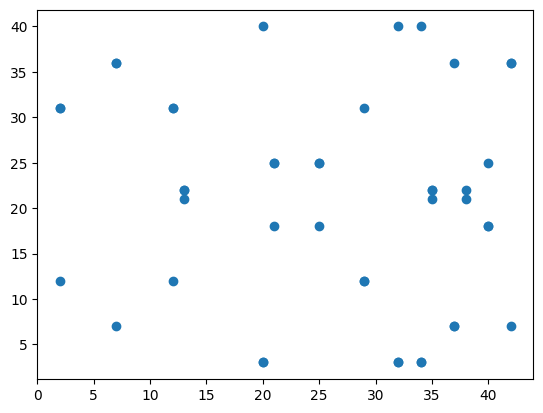

In [300]:
# y^2 = x^3 + a*x + b mod p 

a = 0
b = 7
p = 43 

assert 0 > (-16 * (4 * a**3 + 27 * b**2)), "not negative"

coords = list()
qr = quadratic_residues(p)
print(qr)
for i in range(p): 
  out = (i**3 + a*i + b) % p
  if out in qr: 
    if out != 0: 
      sq_root = tonelli(out, p)
    else: 
      sq_root = 0 
    coords.append([i, sq_root])
    coords.append([i, p - sq_root])

next_x, next_y = coords[0][0], coords[0][1]
points = [(next_x, next_y)]

for i in range(1, p+2): 
  next_x, next_y = add_points(next_x, next_y, coords[0][0], coords[0][1], p, a, b)
  points.append((next_x, next_y))

len(set(points))
plt.scatter(np.asarray(points)[:, 0], np.asarray(points)[:, 1])

In [447]:
# 1. Distributed Key Generation 
# Input 
n = 5 # no. of participants 
t = 3 # threshold to accept signature 
G = coords[0][0], coords[0][1]

# polynomial generation
def generate_polynomial(t, n): 
  # a0 + a1*x + a2*x^2
  coeff = np.random.randint(0, p, size=(t))
  # x^0 + x^1 + x^2
  x_power = np.arange(t)

  shares = list() 
  # out = np.zeros((j, j))
  # for each person 
  for j in range(1, n+1): 
    # [1, 1, 1] * [1, 2, 3]
    x = np.ones(x_power.size) * j 
    # out[j][0] = x[0]
    # [2, 2, 2] ** [0, 1, 2]
    # 1 + 2 + 2^2
    # _ + x + x^2
    out = x ** x_power
    # a0 * 1 + a1 * 2 + a2 * 2^2
    out = coeff * out
    out %= p
    out = out.sum() % p
    shares.append(out.astype(int))
  
  # 
  # for j in range(n): 
  # check to see if public key is correct 
  a_i0 = coeff[0]

  new_x, new_y = G[0], G[1]
  for _ in range(a_i0): 
    new_x, new_y = add_points(new_x, new_y, G[0], G[1], p, a, b)

  return shares, (new_x, new_y)

shares = np.zeros((n, n))
check = [0] * 5

for participant_id in range(n): 
  # generate_polynomial is all done by 1 person
  shares[participant_id], check[participant_id] = generate_polynomial(t, n)

shares_per_person = shares.T
private_keys = (shares_per_person.sum(1) % p).astype(int)

print(f'private keys {private_keys}')
master_secret = int(shares[0].sum() % p)
print(f'master secret: {master_secret}')

new_x, new_y = G[0], G[1]
for _ in range(master_secret): 
  new_x, new_y = add_points(new_x, new_y, G[0], G[1], p, a, b)

print(f'public key: {new_x, new_y}')

# print('shares', shares)
# for i in range(n): 
#   A_x, A_y = 0, 0 
#   temp = list() 
#   new_x, new_y = G[0], G[1]
#   for _ in range(int(shares[0][i])): 
#     new_x, new_y = add_points(new_x, new_y, G[0], G[1], p, a, b)
#   temp.append((new_x, new_y))
#   if len(temp) == 2: 
#     temp = [add_points(temp[0][0], temp[0][1], temp[1][0], temp[1][1], p, a, b)]

# print(temp)

new_check = check.copy()
while len(new_check) != 1: 
  new_x, new_y = add_points(new_check[0][0], new_check[0][1], new_check[1][0], new_check[1][1], p, a, b)
  new_check = [(new_x, new_y)] + new_check[2:]

print(f'check public key: {new_check}')

# test to see if it is correct 

private keys [39 30 35 11  1]
master secret: 27
public key: (35, 21)
check public key: [(34, 40)]


In [310]:
new_check

[(2, 31)]

In [292]:
[1, 2] + [3, 4]

[1, 2, 3, 4]

In [291]:
check

[(7, 36), (7, 36), (7, 36), (7, 36), (7, 36)]

In [286]:
[0] * 5

[0, 0, 0, 0, 0]

In [280]:
shares

array([[3., 4., 3., 0., 0.],
       [0., 4., 4., 0., 2.],
       [4., 1., 4., 3., 3.],
       [2., 0., 4., 4., 0.],
       [3., 3., 4., 1., 4.]])

In [252]:
shares

array([[3., 4., 3., 0., 0.],
       [0., 4., 2., 4., 0.],
       [2., 0., 2., 3., 3.],
       [4., 0., 1., 2., 3.],
       [2., 4., 4., 2., 3.]])

In [27]:
np.array([2, 2, 2]) ** np.array([1, 2, 3])

array([2, 4, 8])

In [7]:
G

(2, 31)